In [1]:
from tensorflow.keras import backend as K
import numpy as np 
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import pathlib as pl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### Loss and Dice

In [2]:
def dice_coef(truth, pred, smooth=1):
    
    true_flat = tf.reshape(truth, [-1])
    pred_flat = tf.reshape(pred, [-1])
    
    intersection = tf.reduce_sum(true_flat*pred_flat)
    return ((2. * intersection)+smooth) / (tf.reduce_sum(true_flat)+tf.reduce_sum(pred_flat) + smooth)


def dice_coef_loss(gt, pred):
    return 1-dice_coef(gt, pred)

### Model

In [216]:
# shrink the number of filters in each layer
shrink = 8

In [4]:
def unet(pretrained_weights = None,input_size = (240,240,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss =dice_coef_loss, metrics = [dice_coef])

    return model


### Load data

In [5]:
base = pl.Path.cwd().parent / "data"
print(base)

with open(base/"inputs.npy", "rb") as f:
    X = np.load(f)
    
with open(base/"labels.npy", "rb") as f:
    Y = np.load(f)

/home-local/remedilw/class/visualizations/data


In [6]:
X = np.reshape(X, [73,240,240,1])
Y = np.reshape(Y, [73,240,240,1])

### split into train, val, test

In [7]:
#43 for train
train_X = X[0:43]
train_Y = Y[0:43]

#10 for val
val_X = X[43:53]
val_Y = Y[43:53]

#20 for test
test_X = X[53:]
test_Y = Y[53:]


In [8]:
test_X.shape

(20, 240, 240, 1)

### Train

In [9]:
model = unet()

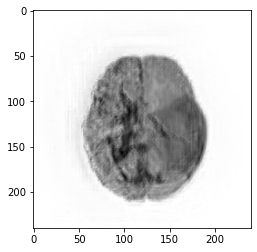

In [10]:
start = 0
stop = start+1
plt.imshow(model( train_X[start:stop,:,:,:] )[0,:,:,0], cmap="gray")

In [11]:
assert train_X.shape == (43,240,240,1) and val_X.shape == (10,240,240,1) and test_X.shape == (20,240,240,1)
assert train_Y.shape == (43,240,240,1) and val_Y.shape == (10,240,240,1) and test_Y.shape == (20,240,240,1)

In [28]:
callbacks_list = []
#es = EarlyStopping(monitor="val_dice_coef", min_delta=1e-8, patience=300, restore_best_weights=True)
w = tf.keras.callbacks.ModelCheckpoint("weights{epoch:08d}.h5",
                                               save_weights_only=True, save_freq=50)
#callbacks_list.append(es)
callbacks_list.append(w)

In [217]:
# history = model.fit(  x=train_X,
#                       y=train_Y,
#                       validation_data=(val_X, val_Y),
#                       batch_size=8,
#                       callbacks=callbacks_list,
#                       epochs=1000,
#                       verbose=1)

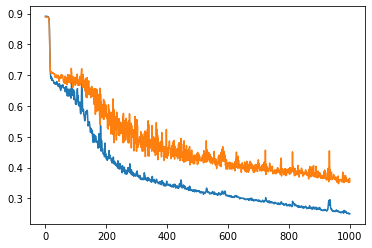

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

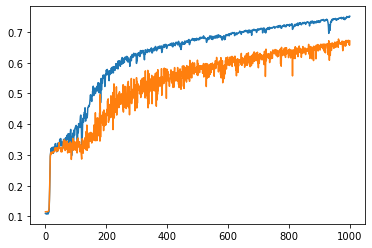

In [31]:
plt.plot(history.history["dice_coef"])
plt.plot(history.history["val_dice_coef"])

### check the trained models

In [161]:
converged = unet()

In [162]:
converged.load_weights("weights00001000.h5")

In [163]:
bad = unet()
bad.load_weights("weights00000200.h5")

### get converged preds

In [164]:
c_train_preds = converged(train_X)

In [165]:
c_val_preds = converged(val_X)

In [166]:
c_test_preds = converged(test_X)

### get bad preds

In [167]:
b_train_preds = bad(train_X)

In [168]:
b_val_preds = bad(val_X)

In [169]:
b_test_preds = bad(test_X)

### convert to np arrays

In [192]:
c_train_preds = c_train_preds.numpy()
c_val_preds = c_val_preds.numpy()
c_test_preds = c_test_preds.numpy()

b_train_preds = b_train_preds.numpy()
b_val_preds = b_val_preds.numpy()
b_test_preds = b_test_preds.numpy()

### look

In [193]:
print(c_train_preds.shape)
print(b_train_preds.shape)
print(c_val_preds.shape)
print(b_val_preds.shape)
print(c_test_preds.shape)
print(b_test_preds.shape)


(43, 240, 240, 1)
(43, 240, 240, 1)
(10, 240, 240, 1)
(10, 240, 240, 1)
(20, 240, 240, 1)
(20, 240, 240, 1)


#### train

In [194]:
start =10

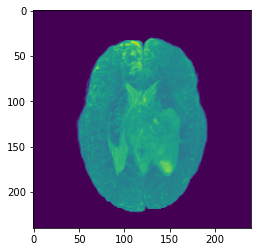

In [195]:
plt.imshow(train_X[start,:,:,0])

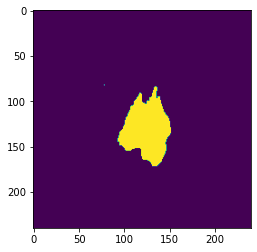

In [196]:
plt.imshow(train_Y[start,:,:,0])

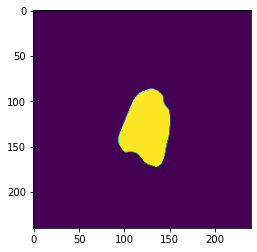

In [197]:
stop = start+1
plt.imshow(converged( train_X[start:stop,:,:,:] )[0,:,:,0])

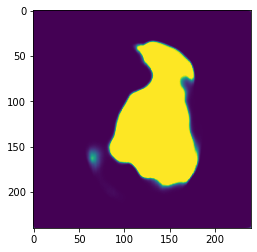

In [198]:
stop = start+1
plt.imshow(bad( train_X[start:stop,:,:,:] )[0,:,:,0])

### val

In [199]:
start=9

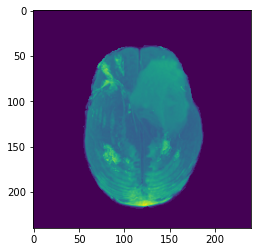

In [200]:
plt.imshow(val_X[start,:,:,0])

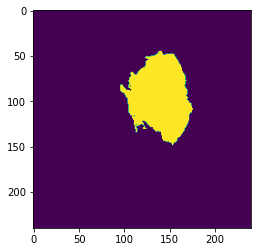

In [201]:
plt.imshow(val_Y[start,:,:,0])

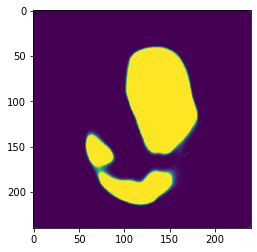

In [202]:
#start = 10
stop = start+1
plt.imshow(bad( val_X[start:stop,:,:,:] )[0,:,:,0])

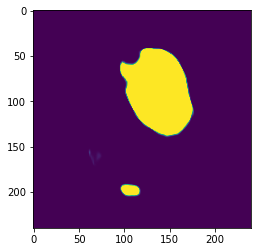

In [203]:
#start = 10
stop = start+1
plt.imshow(converged( val_X[start:stop,:,:,:] )[0,:,:,0])

### test

In [204]:
start=12

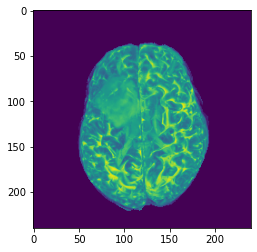

In [205]:
plt.imshow(test_X[start,:,:,0])

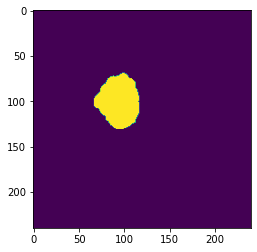

In [206]:
plt.imshow(test_Y[start,:,:,0])

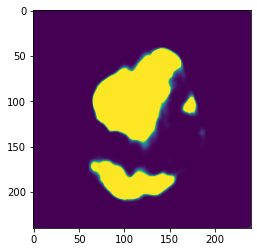

In [207]:
stop = start+1
plt.imshow(bad( test_X[start:stop,:,:,:] )[0,:,:,0])

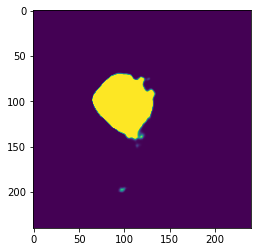

In [208]:
plt.imshow(converged( test_X[start:stop,:,:,:] )[0,:,:,0])

### things look good, save the predictions

In [215]:
with open("converged_epoch_1000_train_preds.npy", "wb") as f:
    
    np.save(f, c_train_preds)
   
with open("converged_epoch_1000_val_preds.npy", "wb") as f:
    
    np.save(f, c_val_preds)
    
with open("converged_epoch_1000_test_preds.npy", "wb") as f:
    
    np.save(f, c_test_preds)
    
    
with open("partial_epoch_200_train_preds.npy", "wb") as f:
    
    np.save(f, b_train_preds)
    
with open("partial_epoch_200_val_preds.npy", "wb") as f:
    
    np.save(f, b_val_preds)
    
with open("partial_epoch_200_test_preds.npy", "wb") as f:
    
    np.save(f, b_test_preds)


### save the train,val,test inputs and labels

In [219]:
with open("train_X.npy", "wb") as f:
    
    np.save(f, train_X)
    
with open("val_X.npy", "wb") as f:
    
    np.save(f, val_X)
    
with open("test_X.npy", "wb") as f:
    
    np.save(f, test_X)
    
    
with open("train_Y.npy", "wb") as f:
    
    np.save(f, train_Y)
    
with open("val_Y.npy", "wb") as f:
    
    np.save(f, val_Y)
    
with open("test_Y.npy", "wb") as f:
    
    np.save(f, test_Y)
    
    